In [ ]:
!sudo apt-get update && sudo apt-get install cmake libopenmpi-dev python3-dev zlib1g-dev > /dev/null 2>&1
!pip install git+https://github.com/hill-a/stable-baselines > /dev/null 2>&1
!pip install gym box2d-py pyvirtualdisplay optuna > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get -y install x11-utils > /dev/null 2>&1
#!pip3 install pyglet==v1.3.2 > /dev/null 2>&1
!pip install gym-tetris ray setproctitle > /dev/null 2>&1
!pip uninstall -y pyarrow > /dev/null 2>&1

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:11 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [92.1 k

In [ ]:
%tensorflow_version 1.x
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import glob
import io
import base64
import numpy as np
import gym as gym
from gym.wrappers import Monitor as colabvideomonitor
from gym import logger as gymlogger
gymlogger.set_level(40) #error only
from collections import namedtuple, deque
import matplotlib
import matplotlib.pyplot as plt
import time
from IPython.display import HTML
from IPython import display as ipythondisplay
import random
import copy
#import tensorflow.contrib.eager as tfe
import tensorflow as tf
#tf.compat.v1.logging.set_verbosity(tf.logging.WARN)
#tf.enable_eager_execution()
import os, operator, sys

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    dirpath = "video"
    # make a generator for all file paths within dirpath
    all_files = ( os.path.join(basedir, filename) for basedir, dirs, files in os.walk(dirpath) for filename in files   )
    sorted_files = (sorted(all_files, key = os.path.getsize,reverse=True))
    %matplotlib inline
    mp4 = sorted_files[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = colabvideomonitor(env, './video', force=True)
  return env

tf.compat.v1.disable_eager_execution()

TensorFlow 1.x selected.


In [ ]:
import gym, optuna

from stable_baselines.deepq.policies import MlpPolicy, CnnPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.deepq import DQN

study = optuna.create_study()

def objective(trial):
  env = gym.make('Boxing-ram-v0')
  # Optional: PPO2 requires a vectorized environment to run
  # the env is now wrapped automatically when passing it to the constructor
  env = DummyVecEnv([lambda: env])
  params = {"gamma":trial.suggest_loguniform('gamma', 0.9, 0.9999), 
            "learning_rate":trial.suggest_loguniform('learning_rate', 1e-4, 1e-2), 
            "buffer_size":int(trial.suggest_uniform("buffer_size",1000,100000)), 
            "exploration_fraction":trial.suggest_loguniform("exploration_fraction",0.05,0.5), 
            "learning_starts":int(trial.suggest_uniform("learning_starts",100,5000)), 
            "target_network_update_freq":int(trial.suggest_uniform("target_network_update_freq",50,1000))}
  model = DQN(MlpPolicy, env, prioritized_replay=True, verbose=0, **params)
  model.learn(total_timesteps=20000)

  iterations = 10

  sum_rewards = 0
  for i in range(iterations):
    obs = env.reset()
    while True:
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action); sum_rewards += rewards
        if done: break
        #env.render()
    env.close()
  return -1*sum_rewards/iterations

study.optimize(objective, n_trials=50)

[I 2020-05-18 17:59:16,347] Finished trial#0 with value: 16.0 with parameters: {'gamma': 0.9635778907894144, 'learning_rate': 0.0011849161266812786, 'buffer_size': 43608.420220183, 'exploration_fraction': 0.0664396861008735, 'learning_starts': 3087.7576677995585, 'target_network_update_freq': 965.212139968774}. Best is trial#0 with value: 16.0.
[I 2020-05-18 18:01:41,951] Finished trial#1 with value: 13.5 with parameters: {'gamma': 0.9150004635452935, 'learning_rate': 0.000368364396925662, 'buffer_size': 93571.24146995878, 'exploration_fraction': 0.27004566357514737, 'learning_starts': 1950.4928991226593, 'target_network_update_freq': 614.1283527788995}. Best is trial#1 with value: 13.5.
[I 2020-05-18 18:03:57,014] Finished trial#2 with value: -0.800000011920929 with parameters: {'gamma': 0.9556057526013201, 'learning_rate': 0.00016130641880018334, 'buffer_size': 46889.99469607495, 'exploration_fraction': 0.17824272082082102, 'learning_starts': 4425.924825081664, 'target_network_update

KeyboardInterrupt: ignored

In [ ]:
import gym, optuna

from stable_baselines.deepq.policies import MlpPolicy, CnnPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.deepq import DQN

study = optuna.create_study()

def objective(trial):
  env = gym.make('Boxing-ram-v0')
  # Optional: PPO2 requires a vectorized environment to run
  # the env is now wrapped automatically when passing it to the constructor
  env = DummyVecEnv([lambda: env])
  params = {"gamma":1-(trial.suggest_loguniform('gamma', 1e-4, 1e-1)), 
            "learning_rate":trial.suggest_loguniform('learning_rate', 1e-4, 1e-1), 
            "buffer_size":int(trial.suggest_uniform("buffer_size",1000,100000)), 
            "exploration_fraction":trial.suggest_loguniform("exploration_fraction",0.01,0.5), 
            "learning_starts":int(trial.suggest_uniform("learning_starts",100,5000)), 
            "target_network_update_freq":int(trial.suggest_uniform("target_network_update_freq",50,1000))}
  model = DQN(MlpPolicy, env, prioritized_replay=False, verbose=0, **params)
  model.learn(total_timesteps=10000)

  iterations = 10

  sum_rewards = 0
  for i in range(iterations):
    obs = env.reset()
    while True:
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action); sum_rewards += rewards
        if done: break
        #env.render()
    env.close()
  return -1*sum_rewards/iterations

study.optimize(objective, n_trials=50)

[I 2020-05-18 18:34:25,059] Finished trial#0 with value: 30.0 with parameters: {'gamma': 0.0015914354820740953, 'learning_rate': 0.07785755421477088, 'buffer_size': 73687.79809209476, 'exploration_fraction': 0.0206451754036758, 'learning_starts': 2791.4616753965747, 'target_network_update_freq': 409.87421577757834}. Best is trial#0 with value: 30.0.
[I 2020-05-18 18:35:35,769] Finished trial#1 with value: 1.7000000476837158 with parameters: {'gamma': 0.00041539158312613644, 'learning_rate': 0.00014315740138792175, 'buffer_size': 21504.36456871291, 'exploration_fraction': 0.06390376325091562, 'learning_starts': 4076.0932337227396, 'target_network_update_freq': 110.74346371560799}. Best is trial#1 with value: 1.7000000476837158.
[I 2020-05-18 18:36:53,115] Finished trial#2 with value: 41.0 with parameters: {'gamma': 0.0012626433327093496, 'learning_rate': 0.003075165096518882, 'buffer_size': 39279.06906892751, 'exploration_fraction': 0.051843224904901675, 'learning_starts': 1263.30093731

KeyboardInterrupt: ignored

In [ ]:
study.best_params

{'buffer_size': 46415.624428729796,
 'exploration_fraction': 0.061554497069647204,
 'gamma': 0.9285108256383847,
 'learning_rate': 1.241070841857104e-05,
 'learning_starts': 1756.375042184865,
 'target_network_update_freq': 600.3013450222551}

In [ ]:
{'gamma': 0.9556057526013201, 'learning_rate': 0.00016130641880018334, 'buffer_size': 46889.99469607495, 'exploration_fraction': 0.17824272082082102, 'learning_starts': 4425.924825081664, 'target_network_update_freq': 253.27911477726863}. Best is trial#2 with value: -0.800000011920929.
{'gamma': 0.9998911343795367, 'learning_rate': 0.00010606164638161712, 'buffer_size': 3203.334321185155, 'exploration_fraction': 0.21101245301203062, 'learning_starts': 1820.503253294042, 'target_network_update_freq': 86.66301860819121}. Best is trial#11 with value: -1.399999976158142.

In [ ]:
!mkdir logs
!mkdir models
!mkdir evaluations

mkdir: cannot create directory ‘logs’: File exists
mkdir: cannot create directory ‘models’: File exists


In [ ]:
# Using optimized parameters:
import gym, optuna

from stable_baselines.deepq.policies import MlpPolicy, CnnPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.deepq import DQN
from stable_baselines.bench import Monitor

from stable_baselines.common.callbacks import BaseCallback, EvalCallback

# Separate evaluation env
eval_env = gym.make('Boxing-ram-v0')
eval_env = DummyVecEnv([lambda: eval_env])
# Use deterministic actions for evaluation
eval_callback = EvalCallback(eval_env, best_model_save_path='models',
                             log_path='evaluations', eval_freq=5000,
                             deterministic=True, render=False)

env = gym.make('Boxing-ram-v0')
# Optional: PPO2 requires a vectorized environment to run
# the env is now wrapped automatically when passing it to the constructor
env = Monitor(env, "logs")
env = DummyVecEnv([lambda: env])
params = {'buffer_size': 50000,
          'exploration_fraction': 0.061554497069647204,
          'gamma': 0.99,
          'learning_rate': 1.2e-04,
          'learning_starts': 2000,
          'target_network_update_freq': 100}
#model = DQN(MlpPolicy, env, prioritized_replay=True, verbose=1, **params)
model = DQN.load("/content/models/best_model.zip")
model.learning_rate = 5e-5
model.set_env(env)
model = model.learn(total_timesteps=int(2e5),callback=eval_callback)

Loading a model without an environment, this model cannot be trained until it has a valid environment.


/usr/local/lib/python3.6/dist-packages/stable_baselines/common/callbacks.py:277: UserWarning:

Training and eval env are not of the same type<stable_baselines.common.base_class._UnvecWrapper object at 0x7fc129c81208> != <stable_baselines.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7fc129cd2fd0>




Eval num_timesteps=5000, episode_reward=-21.60 +/- 2.06
Episode length: 2380.80 +/- 13.69
New best mean reward!
Eval num_timesteps=10000, episode_reward=-20.80 +/- 2.99
Episode length: 2383.20 +/- 15.18
New best mean reward!
Eval num_timesteps=15000, episode_reward=-19.20 +/- 4.12
Episode length: 2375.20 +/- 9.02
New best mean reward!
Eval num_timesteps=20000, episode_reward=-13.00 +/- 8.27
Episode length: 2321.80 +/- 86.94
New best mean reward!
Eval num_timesteps=25000, episode_reward=1.40 +/- 2.65
Episode length: 2377.20 +/- 7.76
New best mean reward!
Eval num_timesteps=30000, episode_reward=-40.60 +/- 3.56
Episode length: 2396.00 +/- 13.34
Eval num_timesteps=35000, episode_reward=-25.20 +/- 4.62
Episode length: 2385.80 +/- 12.72
Eval num_timesteps=40000, episode_reward=-39.80 +/- 3.71
Episode length: 2385.00 +/- 4.69
Eval num_timesteps=45000, episode_reward=-8.00 +/- 5.90
Episode length: 2379.60 +/- 15.16
Eval num_timesteps=50000, episode_reward=-8.60 +/- 4.22
Episode length: 2381.

In [ ]:
# Inference
import gym, optuna

from stable_baselines.deepq.policies import MlpPolicy, CnnPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.deepq import DQN
from stable_baselines.bench import Monitor

from stable_baselines.common.callbacks import BaseCallback, EvalCallback

#bestmodel = DQN.load("/content/models/best_model.zip")
bestmodel = DQN.load("/content/models/best_model.zip")
score = 0
while score <= 66:
  env = wrap_env(gym.make('Boxing-ram-v0'))
  env = DummyVecEnv([lambda: env])
  obs = env.reset(); score = 0
  while True:
      action, _states = bestmodel.predict(obs)
      obs, rewards, dones, info = env.step(action)
      score += rewards
      env.render()
      if dones: break
  env.close()
  print(score)

Loading a model without an environment, this model cannot be trained until it has a valid environment.
[34.]
[33.]
[32.]
[25.]
[15.]
[23.]
[61.]
[22.]
[45.]
[28.]
[57.]
[66.]
[59.]
[38.]
[51.]
[43.]
[54.]
[57.]
[34.]
[30.]
[19.]
[43.]
[12.]
[39.]
[12.]
[66.]
[43.]
[41.]
[38.]
[44.]
[29.]
[27.]
[41.]
[42.]
[61.]
[62.]
[74.]


In [ ]:
show_video()

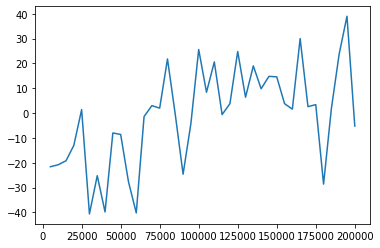

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
with np.load('evaluations/evaluations.npz') as data:
    xs = (data['timesteps'])
    ys = ([np.mean(i) for i in data['results'][:,:,0]])
plt.plot(xs,ys)

In [ ]:
!cp /content/logs/monitor.csv /content/monitor1.csv

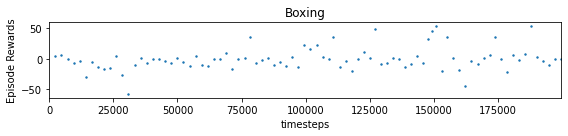

In [ ]:
from stable_baselines import results_plotter
results_plotter.plot_results(["logs"], 200000, results_plotter.X_TIMESTEPS, "Boxing")
plt.show()